In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cmcrameri import cm
from scipy.integrate import cumulative_trapezoid
from pQCD import pQCD

from utils import (
    rcparams,
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre
    )

plt.rcParams.update(rcparams)

In [135]:
# Some example (mu [GeV], n [1/fm^3], p [GeV/fm^3]) values

CET_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

# Keys are different values for the renormalization scale parameter X
pQCD_values = {
    1: [2.6, 6.14, 2334/1000],
    2: [2.6, 6.47, 3823/1000],
    4: [2.6, 6.87, 4284/1000]
}

# Nuclear saturation density
nsat = 0.16

def epsilon(mu, n, p):
    return -p + mu*n

def p(mu, n, pL):
    return pL + cumulative_trapezoid(n, mu)

def pQCD_likelihood_max(e, p, n, X):
    pQCDX = pQCD(X)
    return int(pQCDX.constraints(e0=e,p0=p,n0=n))

In [122]:
class pQCD_constraints:

    def __init__(self, muL, nL, pL, muH, nH, pH):
        """
        Initialize the pQCD_constraints class. Functions taken from Komoltsev 
        & Kurkela 2022, arXiv:2111.05350.
        
        Parameters
        ----------
        muL, nL, pL : float
            Predicted values of the baryon chemical potential [GeV], baryon 
            number density [1/fm^3], and pressure [GeV/fm^3] at low density.
        
        muH, nH, pH : float
            Predicted values of the baryon chemical potential [GeV], baryon 
            number density [1/fm^3], and pressure [GeV/fm^3] at high density.
        """
        self.muL = muL
        self.nL = nL
        self.pL = pL
        self.muH = muH
        self.nH = nH
        self.pH = pH

        self.Deltap = pH - pL
        self.muc = np.sqrt(
            (muL*muH*(muH*nH - muL*nL - 2*self.Deltap))/(muL*nH - muH*nL)
            )
        
        self.epsilonL = epsilon(muL, nL, pL)
        self.epsilonH = epsilon(muH, nH, pH)
        
        self.nmax = np.vectorize(self.nmax_scalar)
        self.nmin = np.vectorize(self.nmin_scalar)

        self.pmax = np.vectorize(self.pmax_scalar)

    def nmin_scalar(self, mu):
        """
        Returns the minimum allowed value of the baryon number density at a
        given baryon chemical potential.
        """
        if self.muL <= mu <= self.muc:
            return self.nL*mu/self.muL
        
        elif self.muc < mu <= self.muH:
            numerator = mu**3*self.nH - mu*self.muH*(self.muH*self.nH - 2*self.Deltap)
            denominator = (mu**2 - self.muL**2)*self.muH
            return numerator/denominator
        
        else:
            raise ValueError('mu is outside the range [muL, muH]')
        
    def nmax_scalar(self, mu):
        """
        Returns the maximum allowed value of the baryon number density at a 
        given baryon chemical potential.
        """
        if self.muL <= mu < self.muc:
            numerator = mu**3*self.nL - mu*self.muL*(self.muL*self.nL + 2*self.Deltap)
            denominator = (mu**2 - self.muH**2)*self.muL
            return numerator/denominator
        
        elif self.muc <= mu <= self.muH:
            return self.nH*mu/self.muH
        
        else:
            raise ValueError('mu is outside the range [muL, muH]')
        
    def nc(self, mu):
        """
        The special EOS for which the speed of sound is equal to the speed of
        light throughout the whole region.
        """
        return (self.nmin(self.muH)*mu)/self.muH

    def pmin(self, mu):
        """
        Returns the minimum allowed value of the pressure at a given baryon
        chemical potential.
        """
        return self.pL + ((mu**2 - self.muL**2)/(2*mu))*self.nmin(mu)
    
    def pmax_scalar(self, mu, n):
        """
        Returns the maximum allowed value of the pressure at a given baryon
        chemical potential and baryon number density.
        """
        if n < self.nc(mu):
            return self.pL + ((mu**2 - self.muL**2)/(2*mu))*n
        
        else:
            return self.pH - ((self.muH**2 - mu**2)/(2*mu))*n
        
    def epsilon_min(self, mu):
        """
        Returns the minimum allowed value of the energy density at a given 
        baryon chemical potential.
        """
        return -self.pmax(mu, self.nmin(mu)) + mu*self.nmin(mu)
    
    def epsilon_max(self, mu):
        """
        Returns the maximum allowed value of the energy density at a given 
        baryon chemical potential.
        """
        return -self.pmin(mu) + mu*self.nmax(mu)
    
    def plot_mu_n(self, mu_array):
        """
        Plots the allowed region of the baryon number density as a function of 
        the baryon chemical potential.

        Parameters
        ----------
        mu_array : array-like
            An array of baryon chemical potential values [GeV].
        """
        fig, ax = plt.subplots()

        ax.plot(mu_array, self.nmin(mu_array), c='C0', label=r'$n_\mathrm{min}$')
        ax.plot(mu_array, self.nmax(mu_array), c='C1', label=r'$n_\mathrm{max}$')

        ax.axvline(self.muc, ls='--', c='C2', label=r'$\mu_\mathrm{c}$')
        ax.plot(mu_array, self.nc(mu_array), ls='--',  c='C3', label='$n_\mathrm{c}$')

        ax.plot(self.muL, self.nL, 'o', c='C4', label=r'$(\mu_\mathrm{L}, n_\mathrm{L})$')
        ax.plot(self.muH, self.nH, 'o', c='C5', label=r'$(\mu_\mathrm{H}, n_\mathrm{H})$')

        ylim = [0, ax.get_ylim()[1]]

        ax.fill_between(mu_array, self.nmax(mu_array), ylim[1], color='k', alpha=0.2)
        ax.fill_between(mu_array, self.nmin(mu_array), ylim[0], color='k', alpha=0.2)

        ax.set_xlabel(r'$\mu$ [GeV]')
        ax.set_ylabel(r'$n$ [1/fm$^3$]')

        ax.legend()

        ax.set_xlim(self.muL, self.muH)
        ax.set_ylim(ylim)

        return fig, ax
    
    def plot_epsilon_p(self, mu_array):
        """
        Plots the allowed region of the pressure as a function of the energy 
        density.

        Parameters
        ----------
        mu_array : array-like
            An array of baryon chemical potential values [GeV].
        """
        fig, ax = plt.subplots()

        ax.set_xscale('log')
        ax.set_yscale('log')

        ax.plot(
            self.epsilon_min(mu_array), 
            self.pmax(mu_array, self.nmin(mu_array)), 
            c='C0',
            label=r'$\epsilon_\mathrm{min}$',
            )
        ax.plot(
            self.epsilon_max(mu_array), 
            self.pmin(mu_array), 
            c='C1',
            label=r'$\epsilon_\mathrm{max}$',
            )

        ax.plot(
            epsilon(mu_array, self.nc(mu_array), self.pmax(mu_array, self.nc(mu_array)))[1:], 
            p(mu_array, self.nc(mu_array), self.pL), 
            ls='--',
            c='C3',
            label=r'$n_c$'
            )

        ax.plot(self.epsilonL, self.pL, 'o', c='C4', label=r'$(\epsilon_\mathrm{L}, p_\mathrm{L})$')
        ax.plot(self.epsilonH, self.pH, 'o', c='C5', label=r'$(\epsilon_\mathrm{H}, p_\mathrm{H})$')

        xlim = ax.get_xlim()

        ax.fill_betweenx(
            self.pmax(mu_array, self.nmin(mu_array)), 
            self.epsilon_min(mu_array), 
            xlim[0], 
            color='k', 
            alpha=0.2
            )
        
        ax.fill_betweenx(
            self.pmin(mu_array), 
            self.epsilon_max(mu_array), 
            xlim[1], 
            color='k', 
            alpha=0.2
            )

        ax.set_xlabel(r'$\epsilon$ [GeV/fm$^3$]')
        ax.set_ylabel(r'$p$ [GeV/fm$^3$]')

        ax.set_xlim(xlim)
        ax.set_ylim(self.pL, self.pH)

        ax.legend()

        return fig, ax

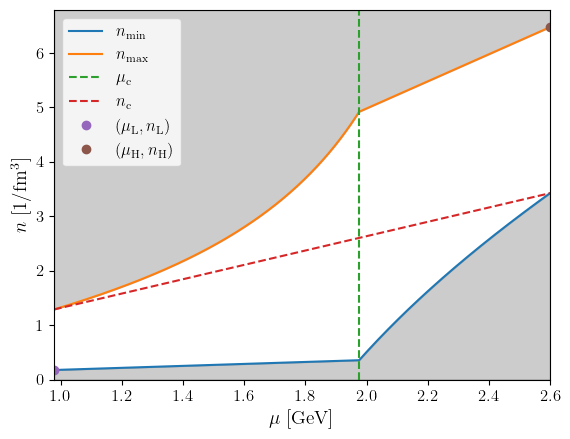

In [123]:
muL, nL, pL = CET_values['stiff']
muH, nH, pH = pQCD_values[2]

mu_array = np.linspace(muL, muH, 1000)

epsilonL = epsilon(muL, nL, pL)
epsilonH = epsilon(muH, nH, pH)

constraints = pQCD_constraints(muL, nL, pL, muH, nH, pH)
fig, ax = constraints.plot_mu_n(mu_array)

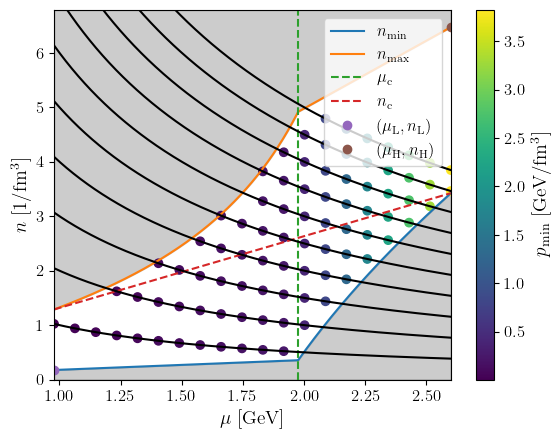

In [80]:
fig, ax = constraints.plot_mu_n(mu_array)

# Overplot some constant-enthalpy lines
h_array = np.linspace(1, 10, 10)

for h in h_array:
    ax.plot(mu_array, h/mu_array, c='k')

# Indicate the minimum pressure along each constant-enthalpy line
reduced_mu_array = np.linspace(muL, muH, 20)
reduced_n_array = np.outer(h_array, 1/reduced_mu_array).flatten()

reduced_mu_array_scatter = np.outer(np.ones(len(h_array)), reduced_mu_array).flatten()

mask = (
    (constraints.nmin(reduced_mu_array_scatter) < reduced_n_array) & 
    (reduced_n_array < constraints.nmax(reduced_mu_array_scatter))
)

im = ax.scatter(
    reduced_mu_array_scatter[mask],
    reduced_n_array[mask],
    c=constraints.pmin(reduced_mu_array_scatter)[mask], 
    cmap='viridis'
    )

cbar = fig.colorbar(im, ax=ax)

cbar.set_label(r'$p_\mathrm{min}$ [GeV/fm$^3$]')

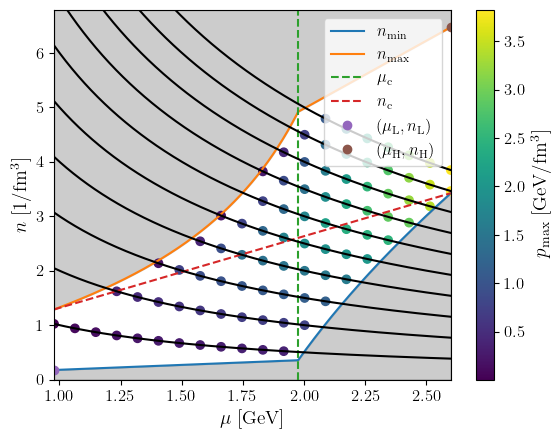

In [111]:
fig, ax = constraints.plot_mu_n(mu_array)

# Overplot some constant-enthalpy lines
h_array = np.linspace(1, 10, 10)

for h in h_array:
    ax.plot(mu_array, h/mu_array, c='k')

# Indicate the maximum pressure along each constant-enthalpy line
reduced_mu_array = np.linspace(muL, muH, 20)
reduced_n_array = np.outer(h_array, 1/reduced_mu_array).flatten()

reduced_mu_array_scatter = np.outer(np.ones(len(h_array)), reduced_mu_array).flatten()

mask = (
    (constraints.nmin(reduced_mu_array_scatter) < reduced_n_array) & 
    (reduced_n_array < constraints.nmax(reduced_mu_array_scatter))
)

im = ax.scatter(
    reduced_mu_array_scatter[mask],
    reduced_n_array[mask],
    c=constraints.pmax(reduced_mu_array_scatter, reduced_n_array)[mask], 
    cmap='viridis'
    )

cbar = fig.colorbar(im, ax=ax)

cbar.set_label(r'$p_\mathrm{max}$ [GeV/fm$^3$]')

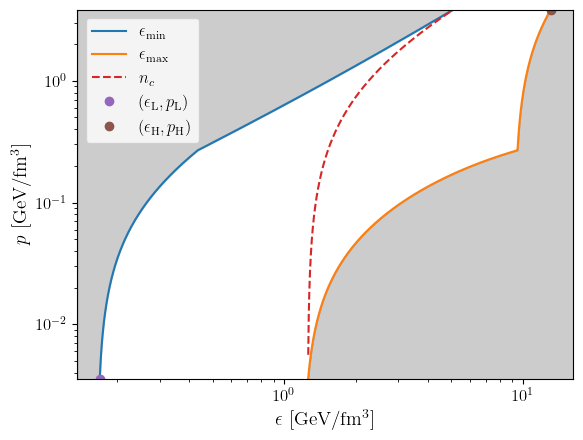

In [124]:
fig, ax = constraints.plot_epsilon_p(mu_array)

In [133]:
df = pd.read_csv('collated_np_all_post.csv')
nonzero_eos = df[df.logweight_total > -np.inf]

nTOV_array = to_nucleons_per_cubic_femtometre(nonzero_eos['rhoc(M@Mmax)'])

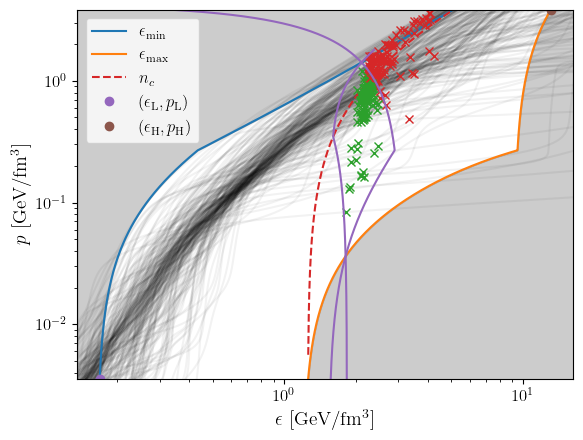

In [153]:
fig, ax = constraints.plot_epsilon_p(mu_array)

n0 = 10*nsat
good_eos_list = []

N_samp = 250
for eos in nonzero_eos.eos[:N_samp]:

    eos = int(eos)

    df = pd.read_csv(f'eos-draws/eos-draw-{eos:06}.csv')

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

    ax.plot(
        energy_density, 
        pressure, 
        alpha=0.05, 
        c='k',
        zorder=0.1
        )
    
    highlight_index = np.argmin((number_density-n0)**2)

    allowed = pQCD_likelihood_max(energy_density[highlight_index], pressure[highlight_index], n0, 2)

    if allowed:
        good_eos_list.append((pressure.values, energy_density.values, number_density.values))

    ax.plot(
        energy_density[highlight_index],
        pressure[highlight_index],
        'x',
        c='C2' if allowed else 'C3'
        )

ax.plot(
    epsilon(mu_array, n0, constraints.pmax(mu_array, n0)), 
    constraints.pmax(mu_array, n0), 
    c='C4'
    )

_ = ax.plot(
    epsilon(mu_array, n0, constraints.pmin(mu_array)), 
    constraints.pmin(mu_array), 
    c='C4'
    )

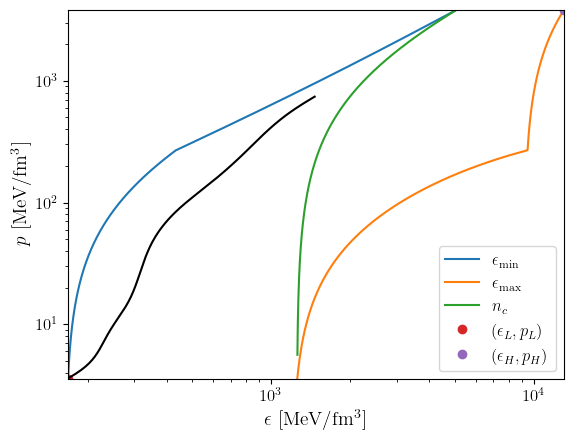

In [128]:
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')

n0 = 7*0.16

ax.plot(
    1000*constraints.epsilon_min(mu_array), 
    1000*constraints.pmax(mu_array, constraints.nmin(mu_array)), 
    label=r'$\epsilon_\mathrm{min}$'
    )
ax.plot(
    1000*constraints.epsilon_max(mu_array), 
    1000*constraints.pmin(mu_array), 
    label=r'$\epsilon_\mathrm{max}$'
    )

ax.plot(
    1000*epsilon(mu_array[1:], constraints.nc(mu_array[1:]), p(mu_array, constraints.nc(mu_array), pL)), 
    1000*p(mu_array, constraints.nc(mu_array), pL), 
    label=r'$n_c$'
    )

ax.plot(1000*epsilonL, 1000*pL, 'o', label=r'$(\epsilon_L, p_L)$')
ax.plot(1000*epsilonH, 1000*pH, 'o', label=r'$(\epsilon_H, p_H)$')

i = 3
pressure, energy_density, number_density = good_eos_list[i]
nterm_index = np.argmin((number_density-n0)**2)

ax.plot(
    energy_density[:nterm_index],
    pressure[:nterm_index],
    'k'
    )

ax.set_xlabel(r'$\epsilon$ [MeV/fm$^3$]')
ax.set_ylabel(r'$p$ [MeV/fm$^3$]')

ax.set_xlim(1000*epsilonL, 1000*epsilonH)
ax.set_ylim(1000*pL, 1000*pH)

ax.legend()

In [ ]:
i = 3
pressure, energy_density, number_density = good_eos_list[i]
nterm_index = np.argmin((number_density-n0)**2)

pressure = pressure[:nterm_index]
energy_density = energy_density[:nterm_index]
number_density = number_density[:nterm_index]

In [ ]:
chemical_potential = (energy_density+pressure)/number_density

In [ ]:
pressure[-1]/1000

In [ ]:
pH

In [ ]:
pressure_alt = p(chemical_potential, number_density, pL)[-1]/1000

In [ ]:
pressure_alt

In [ ]:
# Treat these as new L values?
new_constraints = pQCD_constraints(chemical_potential[-1]/1000, n0, pressure[-1]/1000, muH, nH, pH)

new_mu_array = np.linspace(chemical_potential[-1]/1000, muH, 1000)

NameError: name 'new_constraints' is not defined

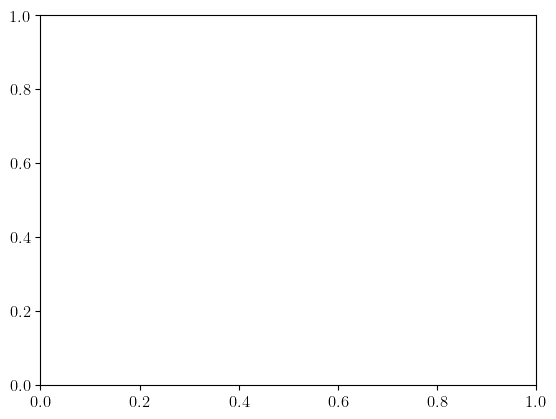

In [129]:
fig, ax = plt.subplots()

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.plot(
    1000*new_constraints.epsilon_min(new_mu_array), 
    1000*new_constraints.pmax(new_mu_array, constraints.nmin(new_mu_array)), 
    label=r'$\epsilon_\mathrm{min}$',
    )
ax.plot(
    1000*new_constraints.epsilon_max(new_mu_array), 
    1000*new_constraints.pmin(new_mu_array), 
    label=r'$\epsilon_\mathrm{max}$'
    )

ax.plot(
    1000*epsilon(new_mu_array[1:], new_constraints.nc(new_mu_array[1:]), p(new_mu_array, new_constraints.nc(new_mu_array), pL)), 
    1000*p(new_mu_array, new_constraints.nc(new_mu_array), pL), 
    label=r'$n_c$'
    )

ax.plot(energy_density[-1], pressure[-1], 'o', label=r'$(\epsilon_L, p_L)$')
ax.plot(1000*epsilonH, 1000*pH, 'o', label=r'$(\epsilon_H, p_H)$')

ax.axvline(1000*new_constraints.epsilon_min(muH))

ax.plot(
    energy_density[:nterm_index],
    pressure[:nterm_index],
    'k'
    )

ax.set_xlabel(r'$\epsilon$ [MeV/fm$^3$]')
ax.set_ylabel(r'$p$ [MeV/fm$^3$]')

ax.set_xlim(1000*epsilonL, 1000*epsilonH)
ax.set_ylim(1000*pL, 1000*pH)

ax.legend()

NameError: name 'new_mu_array' is not defined

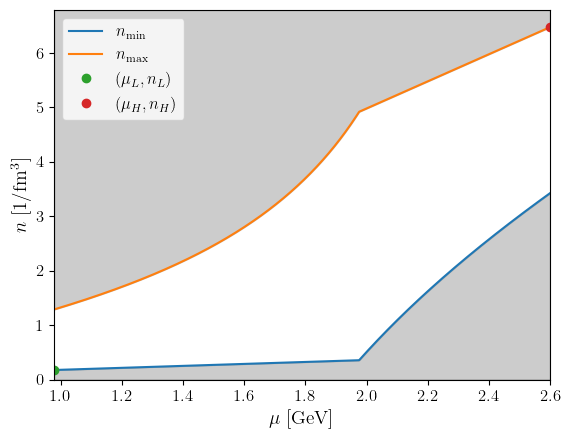

In [130]:
fig, ax = plt.subplots()

ax.plot(mu_array, constraints.nmin(mu_array), label=r'$n_\mathrm{min}$')
ax.plot(mu_array, constraints.nmax(mu_array), label=r'$n_\mathrm{max}$')

ax.plot(muL, nL, 'o', label=r'$(\mu_L, n_L)$')
ax.plot(muH, nH, 'o', label=r'$(\mu_H, n_H)$')

ylim = [0, ax.get_ylim()[1]]

ax.fill_between(mu_array, constraints.nmax(mu_array), ylim[1], color='k', alpha=0.2)
ax.fill_between(mu_array, constraints.nmin(mu_array), ylim[0], color='k', alpha=0.2)

ax.set_xlabel(r'$\mu$ [GeV]')
ax.set_ylabel(r'$n$ [1/fm$^3$]')

ax.legend()

ax.set_xlim(muL, muH)
_ = ax.set_ylim(ylim)

ax.plot(new_mu_array, new_constraints.nmin(new_mu_array), label=r'$n_\mathrm{min}$')
ax.plot(new_mu_array, new_constraints.nmax(new_mu_array), label=r'$n_\mathrm{max}$')

ax.plot(chemical_potential[-1]/1000, n0, 'o', label=r'$(\mu_L, n_L)$')
ax.plot(muH, nH, 'o', label=r'$(\mu_H, n_H)$')

ax.plot(new_mu_array, new_constraints.nc(new_mu_array), ls='--', c='k', label='$n_c$')

ylim = [0, ax.get_ylim()[1]]

ax.set_xlabel(r'$\mu$ [GeV]')
ax.set_ylabel(r'$n$ [1/fm$^3$]')

ax.legend()

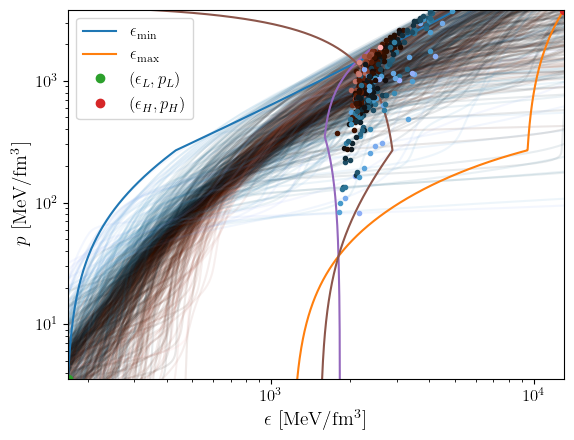

In [131]:
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')

n0 = 10*0.16

for eos, nTOV in zip(nonzero_eos.eos[:500], nTOV_array):

    eos = int(eos)

    df = pd.read_csv(f'eos-draws/eos-draw-{eos:06}.csv')

    pressure = 1000*to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = 1000*to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

    ax.plot(
        energy_density, 
        pressure, 
        alpha=0.1, 
        c=cm.berlin(nTOV_array_norm(nTOV))
        )
    
    highlight_index = np.argmin((number_density-n0)**2)

    allowed = pQCD_likelihood(energy_density[highlight_index]/1000, pressure[highlight_index]/1000, n0, 2)

    ax.plot(
        energy_density[highlight_index],
        pressure[highlight_index],
        '.',
        c=cm.berlin(nTOV_array_norm(nTOV)),
        zorder=10
        )


ax.plot(1000*constraints.epsilon_min(mu_array), 1000*constraints.pmax(mu_array, constraints.nmin(mu_array)), label=r'$\epsilon_\mathrm{min}$')
ax.plot(1000*constraints.epsilon_max(mu_array), 1000*constraints.pmin(mu_array), label=r'$\epsilon_\mathrm{max}$')

ax.plot(1000*epsilonL, 1000*pL, 'o', label=r'$(\epsilon_L, p_L)$')
ax.plot(1000*epsilonH, 1000*pH, 'o', label=r'$(\epsilon_H, p_H)$')

ax.plot(
    1000*epsilon(mu_array, n0, constraints.pmax(mu_array, n0)), 
    1000*constraints.pmax(mu_array, n0), 
    )

ax.plot(
    1000*epsilon(mu_array, n0, constraints.pmin(mu_array)), 
    1000*constraints.pmin(mu_array), 
    )

ax.set_xlabel(r'$\epsilon$ [MeV/fm$^3$]')
ax.set_ylabel(r'$p$ [MeV/fm$^3$]')

ax.set_xlim(1000*epsilonL, 1000*epsilonH)
ax.set_ylim(1000*pL, 1000*pH)

ax.legend()

In [ ]:
fig, ax = plt.subplots()

# ax.set_xscale('log')
ax.set_yscale('log')

n0 = 5*0.16

for eos, nTOV in zip(nonzero_eos.eos[:500], nTOV_array):

    eos = int(eos)

    df = pd.read_csv(f'eos-draws/eos-draw-{eos:06}.csv')

    pressure = 1000*to_GeV_per_cubic_femtometre(df.pressurec2)
    energy_density = 1000*to_GeV_per_cubic_femtometre(df.energy_densityc2)
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

    ax.plot(
        number_density, 
        pressure, 
        alpha=0.1, 
        c=cm.berlin(nTOV_array_norm(nTOV))
        )
    
    highlight_index = np.argmin((number_density-n0)**2)

    allowed = pQCD_likelihood(energy_density[highlight_index]/1000, pressure[highlight_index]/1000, n0, 2)

    ax.plot(
        number_density[highlight_index],
        pressure[highlight_index],
        'x',
        c='C1' if allowed else 'C3'
        )

ax.plot(constraints.nmin(mu_array), 1000*constraints.pmax(mu_array, constraints.nmin(mu_array)), label=r'$n_\mathrm{min}$')
ax.plot(constraints.nmax(mu_array), 1000*constraints.pmin(mu_array), label=r'$n_\mathrm{max}$')

ax.plot(
    constraints.nc(mu_array), 
    1000*constraints.pmax(mu_array, constraints.nc(mu_array)), 
    label=r'$n_c$'
    )

ax.plot(nL, 1000*pL, 'o', label=r'$(n_L, p_L)$')
ax.plot(nH, 1000*pH, 'o', label=r'$(n_H, p_H)$')

# ax.plot(
#     1000*epsilon(mu_array, n0, constraints.pmax(mu_array, n0)), 
#     1000*constraints.pmax(mu_array, n0), 
#     )

# ax.plot(
#     1000*epsilon(mu_array, n0, constraints.pmin(mu_array)), 
#     1000*constraints.pmin(mu_array), 
#     )

for n in [5,8, 20]:
    ax.axvline(0.16*n, ls='--', c='k')

ax.set_xlabel(r'$n$ [1/fm$^3$]')
ax.set_ylabel(r'$p$ [MeV/fm$^3$]')

ax.set_xlim(nL, nH)
ax.set_ylim(1000*pL, 1000*pH)

ax.legend()

In [ ]:
# Let's assume that the EOS has the form
def cubic_eos(mu, a, b, c, d):
    return a*mu**3 + b*mu**2 + c*mu + d

# The integral constraint (that is, that the area under the curve has to equal
# the change in pressure) means that given three of the four parameters then 
# the fourth is determined. For example, if we solve for d:
def d_func(a, b, c, muL, muH, pL, pH):
    DeltaP = pH - pL
    return (DeltaP - (a/4)*(muH**4 - muL**4) - (b/3)*(muH**3 - muL**3) - (c/2)*(muH**2 - muL**2))/(muH - muL)

# The causality constraint can be written in the following way:
def causality_test(a, b, d, mu):
    return np.all(2*a*mu**3 + 3*b*mu**2 >= d)

In [ ]:
rng = np.random.default_rng()

# Let's generate some random values for the parameters
params = rng.uniform(0, 1, size=(1000, 3))

fig, ax = plt.subplots()

ax.plot(mu_array, constraints.nmin(mu_array), label=r'$n_\mathrm{min}$')
ax.plot(mu_array, constraints.nmax(mu_array), label=r'$n_\mathrm{max}$')

ax.plot(muL, nL, 'o', label=r'$(\mu_L, n_L)$')
ax.plot(muH, nH, 'o', label=r'$(\mu_H, n_H)$')

ax.axvline(constraints.muc, ls='--', c='C4', label=r'$\mu_c$')
ax.plot(mu_array, (constraints.nmax(muL)/muL)*mu_array, ls='--', c='C5', label='$n_c$')

ylim = [0, ax.get_ylim()[1]]

valid_eos_list = []
for a, b, c in params:
    d = d_func(a, b, c, muL, muH, pL, pH)
    eos = cubic_eos(mu_array, a, b, c, d)
    if (eos[0] > nL) & causality_test(a, b, d, mu_array):
        valid_eos_list.append(eos)
        ax.plot(mu_array, eos, alpha=0.1, c='k')

ax.fill_between(mu_array, constraints.nmax(mu_array), ylim[1], color='k', alpha=0.2)
ax.fill_between(mu_array, constraints.nmin(mu_array), ylim[0], color='k', alpha=0.2)

ax.set_xlabel(r'$\mu$ [GeV]')
ax.set_ylabel(r'$n$ [1/fm$^3$]')

ax.legend()

ax.set_xlim(muL, muH)
_ = ax.set_ylim(ylim)

In [ ]:
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(
    1000*constraints.epsilon_min(mu_array), 
    1000*constraints.pmax(mu_array, constraints.nmin(mu_array)), 
    label=r'$\epsilon_\mathrm{min}$'
    )

ax.plot(
    1000*constraints.epsilon_max(mu_array), 
    1000*constraints.pmin(mu_array), 
    label=r'$\epsilon_\mathrm{max}$'
    )

ax.plot(
    1000*epsilon(mu_array, constraints.nc(mu_array), constraints.pmax(mu_array, constraints.nc(mu_array))), 
    1000*constraints.pmax(mu_array, constraints.nc(mu_array)), 
    label=r'$n_c$'
    )

ax.plot(
    1000*epsilon(mu_array[1:], constraints.nc(mu_array)[1:], get_pressure(mu_array, constraints.nc(mu_array), pL)),
    1000*get_pressure(mu_array, constraints.nc(mu_array), pL), alpha=1, c='C3', linestyle='--'
    )

# ax.plot(
#     1000*epsilon(mu_array, test_eos(mu_array), constraints.pmax(mu_array, test_eos(mu_array))), 
#     1000*constraints.pmax(mu_array, test_eos(mu_array)), 
#     label=r'test EOS'
#     )

for eos in valid_eos_list:
    p = get_pressure(mu_array, eos, pL)
    ax.plot(
        1000*epsilon(mu_array[1:], eos[1:], p), 
        1000*p, alpha=0.1, c='k'
    )
    # ax.plot(
    #     1000*epsilon(mu_array, eos, constraints.pmax(mu_array, eos)), 
    #     1000*constraints.pmax(mu_array, eos), alpha=0.5, c='k'
    #     )
    # ax.plot(
    #     1000*epsilon(mu_array, eos, constraints.pmin(mu_array)), 
    #     1000*constraints.pmin(mu_array), alpha=0.5, c='k', ls='--'
    # )

ax.plot(1000*epsilonL, 1000*pL, 'o', label=r'$(\epsilon_L, p_L)$')
ax.plot(1000*epsilonH, 1000*pH, 'o', label=r'$(\epsilon_H, p_H)$')

ax.set_xlabel(r'$\epsilon$ [MeV/fm$^3$]')
ax.set_ylabel(r'$p$ [MeV/fm$^3$]')

ax.set_xlim(1000*epsilonL, 1000*epsilonH)
ax.set_ylim(1000*pL, 1000*pH)

ax.legend()

In [ ]:
fig, ax = plt.subplots()

ax.plot(
    1000*constraints.epsilon_min(mu_array), 
    1000*constraints.pmax(mu_array, constraints.nmin(mu_array)), 
    label=r'$\epsilon_\mathrm{min}$'
    )

ax.plot(
    1000*constraints.epsilon_max(mu_array), 
    1000*constraints.pmin(mu_array), 
    label=r'$\epsilon_\mathrm{max}$'
    )

ax.plot(
    1000*epsilon(mu_array[1:], constraints.nc(mu_array)[1:], get_pressure(mu_array, constraints.nc(mu_array), pL)),
    1000*get_pressure(mu_array, constraints.nc(mu_array), pL), alpha=1, c='C3', linestyle='--'
    )

ax.plot(1000*epsilonL, 1000*pL, 'o', label=r'$(\epsilon_L, p_L)$')
ax.plot(1000*epsilonH, 1000*pH, 'o', label=r'$(\epsilon_H, p_H)$')

ax.set_xlabel(r'$\epsilon$ [MeV/fm$^3$]')
ax.set_ylabel(r'$p$ [MeV/fm$^3$]')

ax.set_xlim(1000*epsilonL, 1000*epsilonH)
ax.set_ylim(1000*pL, 1000*pH)

ax.legend()

In [ ]:
def squared_exponential_kernel(t, tp, sigma=1, l=1):
    return sigma**2*np.exp(-(t-tp)**2/(2*l**2))

In [ ]:
N = 200
mu_array = np.linspace(muL, muH, N)
Sigma = np.zeros((N, N))

for i, t in enumerate(mu_array):
    for j, tp in enumerate(mu_array):
        Sigma[i, j] = squared_exponential_kernel(t, tp, sigma=1, l=1)

In [ ]:
fig, ax = plt.subplots()

repeats = 100

for _ in range(repeats):
    ax.plot(mu_array, rng.multivariate_normal(np.zeros(N), Sigma), alpha=0.1, c='k')

In [ ]:
training_x = np.array([muL, muH])
training_y = np.array([nL, nH])

training_dim = len(training_x)

xp = np.append(training_x, mu_array)

In [ ]:
Sigma = np.zeros((N + training_dim, N + training_dim))

for i, t in enumerate(xp):
    for j, tp in enumerate(xp):
        Sigma[i, j] = squared_exponential_kernel(t, tp, sigma=5, l=1)

In [ ]:
# Then we need to condition this thing, and in the process make it dimenion N
# again.

sigma_XX = Sigma[training_dim:, training_dim:]
sigma_YY = Sigma[:training_dim, :training_dim]

sigma_XY = Sigma[training_dim:, :training_dim]
sigma_YX = Sigma[:training_dim, training_dim:]

sigma_YY_inv = np.linalg.inv(sigma_YY)

mup = sigma_XY @ sigma_YY_inv @ training_y # mu_Y is zero?
Sigmap = sigma_XX - sigma_XY @ sigma_YY_inv @ sigma_YX

In [ ]:
fig, ax = plt.subplots()

ax.plot(mu_array, constraints.nmin(mu_array), label=r'$n_\mathrm{min}$')
ax.plot(mu_array, constraints.nmax(mu_array), label=r'$n_\mathrm{max}$')

ax.plot(muL, nL, 'o', label=r'$(\mu_L, n_L)$')
ax.plot(muH, nH, 'o', label=r'$(\mu_H, n_H)$')

ax.axvline(constraints.muc, ls='--', c='C4', label=r'$\mu_c$')
ax.plot(mu_array, (constraints.nmax(muL)/muL)*mu_array, ls='--', c='C5', label='$n_c$')

ylim = [0, ax.get_ylim()[1]]

ax.fill_between(mu_array, constraints.nmax(mu_array), ylim[1], color='k', alpha=0.2)
ax.fill_between(mu_array, constraints.nmin(mu_array), ylim[0], color='k', alpha=0.2)

ax.set_xlabel(r'$\mu$ [GeV]')
ax.set_ylabel(r'$n$ [1/fm$^3$]')

ax.legend()

ax.set_xlim(muL, muH)
_ = ax.set_ylim(ylim)

repeats = 100

for _ in range(repeats):
    eos = rng.multivariate_normal(mup, Sigmap)
    
    ax.plot(mu_array, rng.multivariate_normal(mup, Sigmap), alpha=0.1, c='k')

for x_train, y_train in zip(training_x, training_y):
    ax.scatter(x_train, y_train, c='r', zorder=10)

ax.plot(mu_array, mup, c='r', zorder=10, alpha=0.5)
ax.plot(mu_array, mup + 2*np.sqrt(np.diag(Sigmap)), c='r', zorder=10, alpha=0.5)
ax.plot(mu_array, mup - 2*np.sqrt(np.diag(Sigmap)), c='r', zorder=10, alpha=0.5)